# Ablauf

1) Daten einlesen
2) Daten aufebereiten
    -   Ausreißer identifizieren
3) GSMP-Kenndaten aufbereiten
4) Analyse
    -   Scatterplot Jobs auf Watt + Regression
    -   line chart auf bar chart
    -   Berechnung pro Worker - Idle

# 0. Helfer-Funktionen

In [206]:
def filter_outliers_iqr_per_column(column, multiplier=1.5):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    outliers = ((column < lower_bound) | (column > upper_bound))
    return column[~outliers]

# Function to apply the IQR method for each row in a DataFrame
def filter_outliers_iqr(df, multiplier=1.5):
    return df.apply(filter_outliers_iqr_per_column, axis=0).apply(pd.to_numeric, errors='coerce')


# 1. Daten einlesen

### CSV einlesen

In [207]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from scipy.stats.mstats import winsorize

#read Worker Power CSV
worker_power = pd.read_csv("CSV-mja/2024-02-14 18-30-00 worker power.csv", 
                     header=1, # which row contains column headers
                     index_col=0   ) # which column contains labels

#read zeebe Power CSV
zeebe_power = pd.read_csv("CSV-mja/2024-02-14 18-30-00 zeebe power.csv", 
                     header=1, # which row contains column headers
                     index_col=0   ) # which column contains labels

#read Worker: Jobs Finished CSV
worker_jobs_finished = pd.read_csv("CSV-mja/2024-02-14 18-30-00 worker job completion.csv", 
                     header=1, # which row contains column headers
                     index_col=0   ) # which column contains labels

#read Worker: Jobs Started CSV
worker_jobs_started = pd.read_csv("CSV-mja/2024-02-14 18-30-00 worker job creation.csv", 
                     header=1, # which row contains column headers
                     index_col=0   ) # which column contains labels

#read Zeebe gRPC CSV
zeebe_grpc = pd.read_csv("CSV-mja/2024-02-14 18-30-00 zeebe grpc.csv", 
                     header=1, # which row contains column headers
                     index_col=0   ) # which column contains labels

#read Zeebe Job Creation CSV
zeebe_job_creation = pd.read_csv("CSV-mja/2024-02-14 18-30-00 zeebe job creation.csv", 
                     header=1, # which row contains column headers
                     index_col=0   ) # which column contains labels

#read Zeebe Job Completion CSV
zeebe_job_completion = pd.read_csv("CSV-mja/2024-02-14 18-30-00 zeebe job completion.csv", 
                     header=1, # which row contains column headers
                     index_col=0   ) # which column contains labels

zeebe_power


,camunda-platform-elasticsearch-master-0 / camunda8 / PKG,camunda-platform-elasticsearch-master-1 / camunda8 / PKG,camunda-platform-operate-5bc7c489c4-8zrg4 / camunda8 / PKG,camunda-platform-tasklist-9968d5594-9257r / camunda8 / PKG,camunda-platform-zeebe-0 / camunda8 / PKG,camunda-platform-zeebe-gateway-5ff76496c4-n9kzj / camunda8 / PKG,camunda-platform-elasticsearch-master-0 / camunda8 / DRAM,camunda-platform-elasticsearch-master-1 / camunda8 / DRAM,camunda-platform-operate-5bc7c489c4-8zrg4 / camunda8 / DRAM,camunda-platform-tasklist-9968d5594-9257r / camunda8 / DRAM,camunda-platform-zeebe-0 / camunda8 / DRAM,camunda-platform-zeebe-gateway-5ff76496c4-n9kzj / camunda8 / DRAM,camunda-platform-elasticsearch-master-0 / camunda8 / OTHER,camunda-platform-elasticsearch-master-1 / camunda8 / OTHER,camunda-platform-operate-5bc7c489c4-8zrg4 / camunda8 / OTHER,camunda-platform-tasklist-9968d5594-9257r / camunda8 / OTHER,camunda-platform-zeebe-0 / camunda8 / OTHER,camunda-platform-zeebe-gateway-5ff76496c4-n9kzj / camunda8 / OTHER
Time,,,,,,,,,,,,,,,,,,
2024-02-14 18:30:00,0.544,0.485,0.242,0.237,0.526,0.300,0.0468,0.0468,0.0234,0.0234,0.0234,0.0234,0,0,0,0,0,0
2024-02-14 18:30:10,0.350,0.379,0.172,0.170,0.329,0.203,0.0402,0.0402,0.0201,0.0201,0.0201,0.0201,0,0,0,0,0,0
2024-02-14 18:30:20,0.362,0.363,0.174,0.171,0.412,0.203,0.0456,0.0456,0.0228,0.0228,0.0228,0.0228,0,0,0,0,0,0
2024-02-14 18:30:30,0.518,0.478,0.241,0.234,0.490,0.277,0.0456,0.0456,0.0228,0.0228,0.0228,0.0228,0,0,0,0,0,0
2024-02-14 18:30:40,0.356,0.381,0.329,0.173,0.330,0.190,0.0342,0.0342,0.0171,0.0171,0.0171,0.0171,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-15 04:59:20,0.368,0.364,0.189,0.175,0.402,0.258,0.0360,0.0345,0.0174,0.0168,0.0183,0.0174,0,0,0,0,0,0
2024-02-15 04:59:30,0.504,0.472,0.243,0.234,0.470,0.286,0.0480,0.0453,0.0228,0.0225,0.0240,0.0228,0,0,0,0,0,0
2024-02-15 04:59:40,1.290,0.357,0.177,0.175,0.287,0.200,0.0429,0.0348,0.0174,0.0171,0.0180,0.0171,0,0,0,0,0,0


**Log-Datei einlesen**

In [208]:
LOG_PATH = "shell-scripts/logs/mja/"
LOG_NAME = "mja2.sh-2024-02-14-18-30-00-load_generator_8x90_parallel"

# read all 3 log file of START times

def read_start_times(LOG_PATH = LOG_PATH,LOG_NAME = LOG_NAME):
    start_times = []
    settings= []

    with open(LOG_PATH+LOG_NAME, "r") as file:
        log_lines = file.readlines()

    # remove newline-character, 
    for i, time in enumerate(log_lines):
        line = time.split()

        #append and remove dash between time and date to match index of CSVs
        start_times.append(line[0][:10] + " " + line[0][11:])

        settings.append(line[1])

    return start_times, settings

start_times, settings = read_start_times()

# 2. Daten aufbereiten

1) Addiere alle Messwerte von Kepler
2) Generiere Leerlauf-Muster
3) Subtrahiere Leerlauf-Muster

4) Vereine Completion und Power
5) Generiere Durchsatz-Buckets
6) Berechne Outlier pro Bucket

### Messwerte aus Kepler einlesen und summieren

In [209]:
completion_and_power = pd.DataFrame()

worker_cols = [col for col in worker_power.columns if 'restworkerjava' in col ]
zeebe_cols = [col for col in zeebe_power.columns if 'zeebe' in col ]

# sum up PKG + DRAM + OTHER for each time stamp
completion_and_power['worker_power'] = worker_power[worker_cols].sum(axis=1)
completion_and_power['zeebe_power'] = zeebe_power[zeebe_cols].sum(axis=1)

### Durchsatzwerte aus Worker, Zeebe und gRPC einlesen

In [210]:
completion_and_power['jobs_started'] = worker_jobs_started['worker'] // 1
completion_and_power['jobs_finished'] = worker_jobs_finished['worker'] // 1
completion_and_power['jobs_open'] = completion_and_power['jobs_started'] - completion_and_power['jobs_finished']
completion_and_power['grpc_activation_ok'] = zeebe_grpc['ActivateJobs (OK)']
completion_and_power['grpc_activation_exhausted'] = zeebe_grpc['ActivateJobs (RESOURCE_EXHAUSTED)']
completion_and_power['grpc_activation_total'] = completion_and_power['grpc_activation_ok'] + completion_and_power['grpc_activation_exhausted']
completion_and_power['grpc_completion_ok'] = zeebe_grpc['CompleteJob (OK)']
completion_and_power['zeebe_job_creation'] = zeebe_job_creation['Job creation camunda8']
completion_and_power['zeebe_job_completion'] = zeebe_job_completion['Job completion camunda8']

### Generiere Leerlauf-Muster + Subtrahiere Leerlauf-Muster

In [211]:
def create_idle_pattern(column):
    # set all completion >= 1 to NaN

    idle_power = completion_and_power.copy()
    idle_power[(idle_power['jobs_started'] >= 1) & (idle_power['jobs_finished'] >= 1)] = np.nan


    # generate medians for 00:00, 00:10, 00:20
    

    # reshape series
    idle_pattern = pd.DataFrame(idle_power[column][:-1].to_numpy().reshape(-1, 3), columns=['00:00', '00:10', '00:20'])
    idle_pattern = filter_outliers_iqr(idle_pattern)

    medians = idle_pattern.median(axis=0)

    return medians

worker_idle_medians = create_idle_pattern('worker_power')
zeebe_idle_medians = create_idle_pattern('zeebe_power')


In [212]:
def remove_idle_power(df, pattern, column):
    pattern_series = pd.Series()
    
    difference = 0
    
    # repeat the pattern until length of df.index is reached
    while len(pattern_series) < len(df.index):
        pattern_series = pd.concat([pattern_series, pattern])
        difference = len(pattern_series) - len(df.index)

    pattern_series = pattern_series[:-difference]
    pattern_series.index = df.index

    pattern_series = pattern_series.apply(pd.to_numeric, errors='coerce')

    df[f"{column}_no_idle"] = df[column] - pattern_series
    df[f"{column}_idle"] = pattern_series


    return df

cap_no_idle = remove_idle_power(completion_and_power, worker_idle_medians, "worker_power")
cap_no_idle = remove_idle_power(completion_and_power, zeebe_idle_medians, "zeebe_power")

### Generiere Energieverbrauch pro Job

In [213]:
cap_no_idle['worker_power_per_job_no_idle'] = cap_no_idle['worker_power_no_idle'] / cap_no_idle['jobs_started']
cap_no_idle['zeebe_power_per_job_no_idle'] = cap_no_idle['zeebe_power_no_idle'] / cap_no_idle['jobs_started']

### Entferne Zeitpunkte ohne Durchsatz

In [214]:
cap_no_idle = cap_no_idle[(cap_no_idle['jobs_started'] >= 1) & (cap_no_idle['jobs_finished'] >= 1)]

### Teile Messreihen nach Konfiguration


In [215]:

START_MJA8 = start_times[8]
# before first entry of mja64, there was 1 min of waiting for new worker and 5 minutes of cooloff - so 360 seconds -> 36 entries in index
end_mja8_index = completion_and_power.index.get_loc(start_times[90]) - 36
END_MJA8 = completion_and_power.index[end_mja8_index]

START_MJA64 = start_times[104]
end_mja64_index = completion_and_power.index.get_loc(start_times[180]) - 36
END_MJA64 = completion_and_power.index[end_mja64_index]

START_MJA512 = start_times[188]
# End for mja512 not needed, since we cut the zero throughput times later on

data_8 = cap_no_idle.loc[START_MJA8:END_MJA8,:]
data_64 = cap_no_idle.loc[START_MJA64:END_MJA64,:]
data_512 = cap_no_idle.loc[START_MJA512:,:]

### Sortiere nach Durchsatz

In [216]:
THROUGHPUT_COLUMN = 'jobs_finished'

sorted_8 = data_8.sort_values(by=THROUGHPUT_COLUMN)
sorted_64 = data_64.sort_values(by=THROUGHPUT_COLUMN)
sorted_512 = data_512.sort_values(by=THROUGHPUT_COLUMN)
all_sorted = cap_no_idle.sort_values(by=THROUGHPUT_COLUMN)


### Generiere Durchsatz-Buckets pro Job


In [217]:
# Bucket Params
BUCKET_WIDTH = 30

def create_buckets(df, col, bucket_width):

    # create limits for buckets
    max_throughput = int(df[col].max())
    min_throughput = int(df[col].min())
    span_throughput = int(max_throughput - min_throughput)

    # number of buckets
    num_buckets = (span_throughput // bucket_width) + 1

    buckets = [i for i in range(min_throughput ,max_throughput + bucket_width, bucket_width)]
    bucket_labels = [f"{buckets[i]} - {buckets[i+1]}" for i in range(len(buckets) - 1)]

    return buckets, bucket_labels


buckets, bucket_labels = create_buckets(all_sorted, 'jobs_started', BUCKET_WIDTH)



### Sortiere nach Buckets

In [218]:
def group_by_bucket(sorted_df, groupby, grouped_col, bucket_list):
    df_grouped = pd.DataFrame()

    grouped_list = [sorted_df[
            (sorted_df[groupby] >= bucket_list[i]) 
            & 
            (sorted_df[groupby] < bucket_list[i + 1])
            ]
            [grouped_col]
            .reset_index(drop=True) 
            for i in range(len(bucket_list) - 1)]

    temp = pd.concat(grouped_list, axis=1)

    temp.columns = bucket_list[0:len(bucket_list) - 1]

    return temp

**worker**

In [219]:
grouped_8 = group_by_bucket(sorted_8, 'jobs_started', 'worker_power_no_idle', buckets)
grouped_64 = group_by_bucket(sorted_64, 'jobs_started', 'worker_power_no_idle', buckets)
grouped_512 = group_by_bucket(sorted_512, 'jobs_started', 'worker_power_no_idle', buckets)

**zeebe**

In [220]:
grouped_8_zeebe = group_by_bucket(sorted_8, 'jobs_started', 'zeebe_power_no_idle', buckets)
grouped_64_zeebe = group_by_bucket(sorted_64, 'jobs_started', 'zeebe_power_no_idle', buckets)
grouped_512_zeebe = group_by_bucket(sorted_512, 'jobs_started', 'zeebe_power_no_idle', buckets)

### Entferne Ausreißer

**worker**

In [221]:
clean_8 = filter_outliers_iqr(grouped_8)
clean_64 = filter_outliers_iqr(grouped_64)
clean_512 = filter_outliers_iqr(grouped_512)

**zeebe**

In [222]:
clean_8_zeebe = filter_outliers_iqr(grouped_8_zeebe)
clean_64_zeebe = filter_outliers_iqr(grouped_64_zeebe)
clean_512_zeebe = filter_outliers_iqr(grouped_512_zeebe)

#### Entferne Buckets unter X Einträgen

In [250]:
BUCKET_MINIMUM = 30

clean_8 = clean_8.dropna(axis=1, thresh=BUCKET_MINIMUM)
clean_64 = clean_64.dropna(axis=1, thresh=BUCKET_MINIMUM)
clean_512 = clean_512.dropna(axis=1, thresh=BUCKET_MINIMUM)

clean_8_zeebe = clean_8_zeebe.dropna(axis=1, thresh=BUCKET_MINIMUM)
clean_64_zeebe = clean_64_zeebe.dropna(axis=1, thresh=BUCKET_MINIMUM)
clean_512_zeebe = clean_512_zeebe.dropna(axis=1, thresh=BUCKET_MINIMUM)



In [251]:
lmh_hist = pd.DataFrame()

lmh_hist['mja8'] = clean_8.count()
lmh_hist['mja64'] = clean_64.count()
lmh_hist['mja1024'] = clean_512.count()

lmh_hist = lmh_hist.dropna(axis=0, thresh=3)

<Axes: title={'center': 'Sample Sizes in Buckets'}>

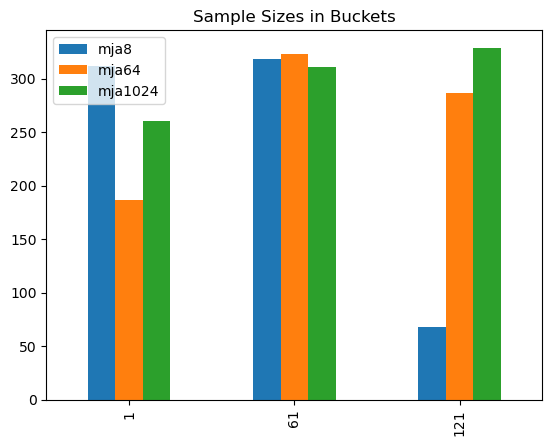

In [252]:
lmh_hist.plot(kind='bar', title='Sample Sizes in Buckets')

In [253]:
lmh_hist

,mja8,mja64,mja1024
1,312,187.0,260.0
61,318,323.0,311.0
121,68,287.0,329.0


### Erstelle Vergleichstabelle
Mediane nach Durchsatz sortiert

**worker**

In [254]:
hml_median = pd.DataFrame()
hml_median['mja8'] = clean_8.median()
hml_median['mja64'] = clean_64.median()
hml_median['mja512'] = clean_512.median()

**zeebe**

In [255]:
hml_median_zeebe = pd.DataFrame()
hml_median_zeebe['mja8'] = clean_8_zeebe.median()
hml_median_zeebe['mja64'] = clean_64_zeebe.median()
hml_median_zeebe['mja512'] = clean_512_zeebe.median()

# Plotting

In [256]:
# PLOT SETTINGS

figsize = [9,8]
whis= [0,100]

# LABELS

labels = {
    'power' : 'Energieverbrauch in Watt pro Sekunde',
    'throughput' : 'Jobs pro Sekunde'
}




<Axes: title={'center': 'Energieverbrauch nach Durchsatz im Median (Zeebe)'}, xlabel='Jobs pro Sekunde', ylabel='Energieverbrauch in Watt pro Sekunde'>

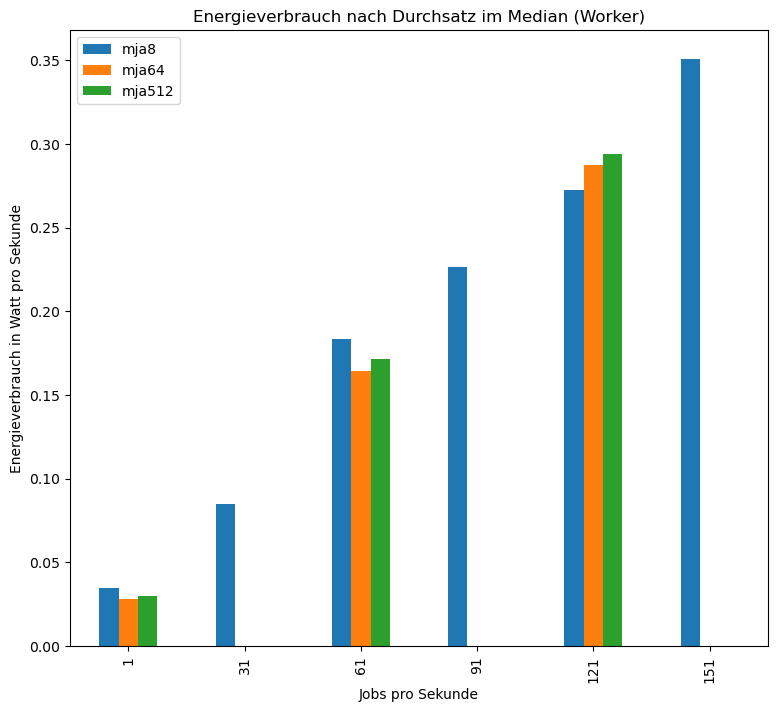

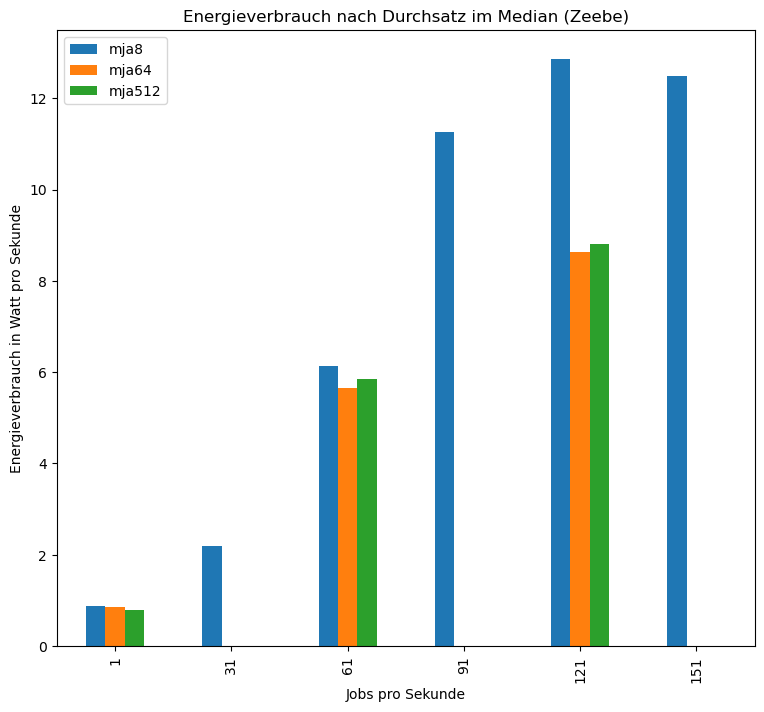

In [257]:
hml_median.plot(kind='bar', rot=90, figsize=figsize, title="Energieverbrauch nach Durchsatz im Median (Worker)", ylabel=labels['power'], xlabel=labels['throughput'])
hml_median_zeebe.plot(kind='bar', rot=90, figsize=figsize, title="Energieverbrauch nach Durchsatz im Median (Zeebe)", ylabel=labels['power'], xlabel=labels['throughput'])

### Job-Aktivierung

In [258]:
sorted_8.columns

Index(['worker_power', 'zeebe_power', 'jobs_started', 'jobs_finished',
       'jobs_open', 'grpc_activation_ok', 'grpc_activation_exhausted',
       'grpc_activation_total', 'grpc_completion_ok', 'zeebe_job_creation',
       'zeebe_job_completion', 'worker_power_no_idle', 'worker_power_idle',
       'zeebe_power_no_idle', 'zeebe_power_idle',
       'worker_power_per_job_no_idle', 'zeebe_power_per_job_no_idle'],
      dtype='object')

In [281]:
SORT_BY='jobs_started'
SORTED_COLUMN='grpc_activation_ok'

job_Activation_buckets, job_Activation_labels = create_buckets(all_sorted, SORT_BY, 10)
print(job_Activation_buckets)


activation_over_throughput_8_zeebe = filter_outliers_iqr(group_by_bucket(sorted_8, SORT_BY, SORTED_COLUMN, job_Activation_buckets)).dropna(axis=1, thresh=10)
activation_over_throughput_64_zeebe = filter_outliers_iqr(group_by_bucket(sorted_64, SORT_BY, SORTED_COLUMN, job_Activation_buckets)).dropna(axis=1, thresh=10)
activation_over_throughput_512_zeebe = filter_outliers_iqr(group_by_bucket(sorted_512, SORT_BY, SORTED_COLUMN, job_Activation_buckets)).dropna(axis=1, thresh=10)

hml_median_zeebe_activation = pd.DataFrame()
hml_median_zeebe_activation['mja8'] = activation_over_throughput_8_zeebe.median()
hml_median_zeebe_activation['mja64'] = activation_over_throughput_64_zeebe.median()
hml_median_zeebe_activation['mja512'] = activation_over_throughput_512_zeebe.median()

[1, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101, 111, 121, 131, 141, 151, 161, 171, 181, 191, 201, 211, 221, 231, 241, 251]


<Axes: title={'center': 'Jobaktivierungen nach Durchsatz im Median (Zeebe)'}, xlabel='Jobs pro Sekunde', ylabel='Energieverbrauch in Watt pro Sekunde'>

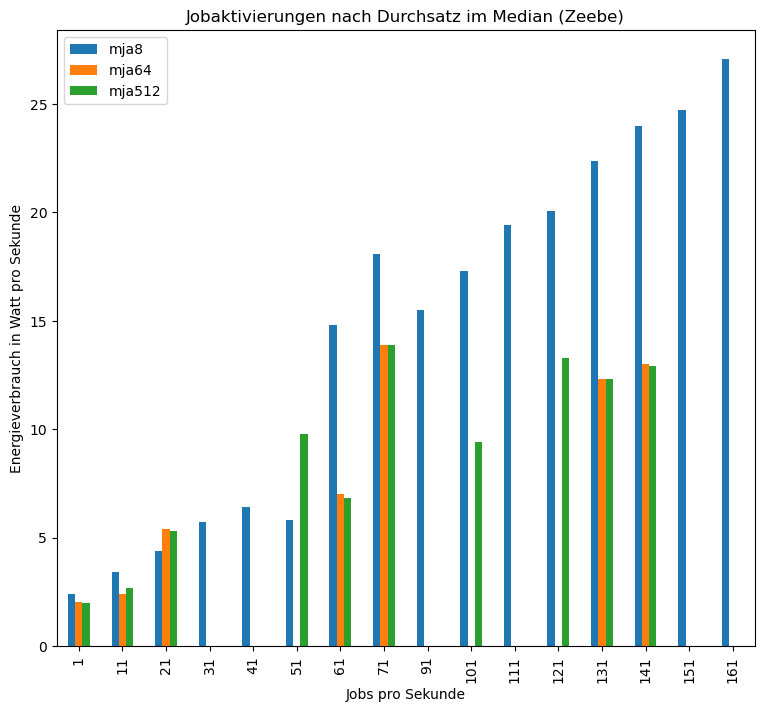

In [282]:
# hml_median.plot(kind='bar', rot=90, figsize=figsize, title="Energieverbrauch nach Durchsatz im Median (Worker)", ylabel=labels['power'], xlabel=labels['throughput'])
hml_median_zeebe_activation.plot(kind='bar', rot=90, figsize=figsize, title="Jobaktivierungen nach Durchsatz im Median (Zeebe)", ylabel=labels['power'], xlabel=labels['throughput'])

In [ ]:
SORT_BY='jobs_started'
SORTED_COLUMN_WORKER='worker_power_per_job_no_idle'
SORTED_COLUMN_ZEEBE='zeebe_power_per_job_no_idle'

power_per_job_8_zeebe = filter_outliers_iqr(group_by_bucket(sorted_8, SORT_BY, SORTED_COLUMN_ZEEBE, buckets)).dropna(axis=1, thresh=10)
power_per_job_64_zeebe = filter_outliers_iqr(group_by_bucket(sorted_64, SORT_BY, SORTED_COLUMN_ZEEBE, buckets)).dropna(axis=1, thresh=10)
power_per_job_512_zeebe = filter_outliers_iqr(group_by_bucket(sorted_512, SORT_BY, SORTED_COLUMN_ZEEBE, buckets)).dropna(axis=1, thresh=10)

hml_median_zeebe_per_job = pd.DataFrame()
hml_median_zeebe_per_job['mja8'] = power_per_job_8_zeebe.median()
hml_median_zeebe_per_job['mja64'] = power_per_job_64_zeebe.median()
hml_median_zeebe_per_job['mja512'] = power_per_job_512_zeebe.median()

power_per_job_8_worker = filter_outliers_iqr(group_by_bucket(sorted_8, SORT_BY, SORTED_COLUMN_WORKER, buckets)).dropna(axis=1, thresh=10)
power_per_job_64_worker = filter_outliers_iqr(group_by_bucket(sorted_64, SORT_BY, SORTED_COLUMN_WORKER, buckets)).dropna(axis=1, thresh=10)
power_per_job_512_worker = filter_outliers_iqr(group_by_bucket(sorted_512, SORT_BY, SORTED_COLUMN_WORKER, buckets)).dropna(axis=1, thresh=10)

hml_median_worker_per_job = pd.DataFrame()
hml_median_worker_per_job['mja8'] = power_per_job_8_worker.median()
hml_median_worker_per_job['mja64'] = power_per_job_64_worker.median()
hml_median_worker_per_job['mja512'] = power_per_job_512_worker.median()

In [ ]:
# hml_median.plot(kind='bar', rot=90, figsize=figsize, title="Energieverbrauch nach Durchsatz im Median (Worker)", ylabel=labels['power'], xlabel=labels['throughput'])
hml_median_zeebe_activation.plot(kind='bar', rot=90, figsize=figsize, title="Jobaktivierungen nach Durchsatz im Median (Zeebe)", ylabel=labels['power'], xlabel=labels['throughput'])